**Project 1**

Work in groups of 2-5. Prepare ~10 slides where one slide describes your setup and analysis, main results, challenges/suprises and take-home message.

Everyone should do the first part of the project. You can then choose from one of the three themes for part 2.

For the first part of the project, you will be working on a high-dimensional data from the cancer genom atlas (TCGA). The data matrices contain gene expression (relates to how much of a gene product (protein) is being produced) for 2000 randomly selected genes over 2887 cancer samples. There are 6 types of cancers in this data set. You don't need to know any bio for the project - just think of this as a 6 class data set with 2000 features.

You will notice that the classes are quite imbalanced. There are a lot of breast cancer samples and very few uterine samples, etc.

All of the project themes aim at you exploring how to make a method "crash" in some way - meaning that you illustrate when a particular method or approach would be a bad choice, or simple a situation when things might not work out as hoped for.

For all tasks, you have to repeat the exercise in order to be able to draw conclusions. That is, one single run of a data analysis task or simulation has very limited information so repeat a few times to ensure you are not drawing conclusions based on a random "fluke".

**Part 1 - Dimension reduction and predictive modeling**

*Everyone should do this task.*

High-dimensional data tend to be "data hungry". For some methods, high-dimensionality can results in a large number of parameters having to be estimated and as a consequence you might high estimation variance. It is therefore quite common to try to reduce the dimensionality of the problem prior to modeling. (An alternative to this is filtering where you remove a (possibly large) subset of features before modeling.

In class we have so-far discussed a linear dimension reduction technique, PCA and some basic filtering based on e.g. variance, t or F-tests.

You should explore at least 3 different classifiers of different character, from flexible to rigid (e.g. small k to large k in k-nearest neighbors). Feel free to try any other classifier you like as long as you explain if they are flexible or rigid.

1. Perform cross-validation to select the number of principal components that optimizing predictive performance.
2. Perform cross-validation to select the number features (genes) that optimizing predictive performance.
3. Demonstrate the optimism of training by comparing the difference between training error, cross-validation error after selection of optimal PCs or features, and test error performance. Discuss the difference for the fleixble and rigid classifiers in terms of optimism.
4. Repeat the above for 3 different size training sets and discuss the results.

*Voluntary - something to think about*

1. Can you construct a data set where PCA dimension reduction should improve classification performance?
2. Can you construct a data set where PCA dimension reduction should reduce classification performance?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

In [4]:
##### Load dataset ######
file_path_data = "TCGAdata.txt"
file_path_labels = "TCGAlabels.txt"

df_data = pd.read_csv(
    file_path_data, 
    delim_whitespace=True,  # Use whitespace as the delimiter
    header=0,               # Use the first line as the header
    quotechar='"'           # Specify the quote character used
)

df_labels = pd.read_csv(
    file_path_labels, 
    delim_whitespace=True,  
    header=0,               
    quotechar='"'           
)

df = pd.merge(df_data, df_labels, left_index=True, right_index=True, how='left')

df.head(1)
print(df.shape)

(2887, 2001)


In [5]:
##### Split into train and test set ######
X = df.iloc[:, :-1] #features
y = df.iloc[:, -1] #Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42 )

print(X_train.shape)

(1732, 2000)


In [6]:
##### Center and Normalize ######

# Last column is the label
#features = df.iloc[:, :-1] 
#labels = df.iloc[:, -1]  
#print(df.shape)

# Centering and normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#print(features_scaled.mean())
#print(features.mean())

# Convert the normalized features back to a DataFrame
#features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Reattach the labels to the features DataFrame
#final_df = pd.concat([features_scaled_df, labels.reset_index(drop=True)], axis=1)

# Show the first few rows of the final, normalized dataset
#print(final_df.head())

(-1.0, 50.0)

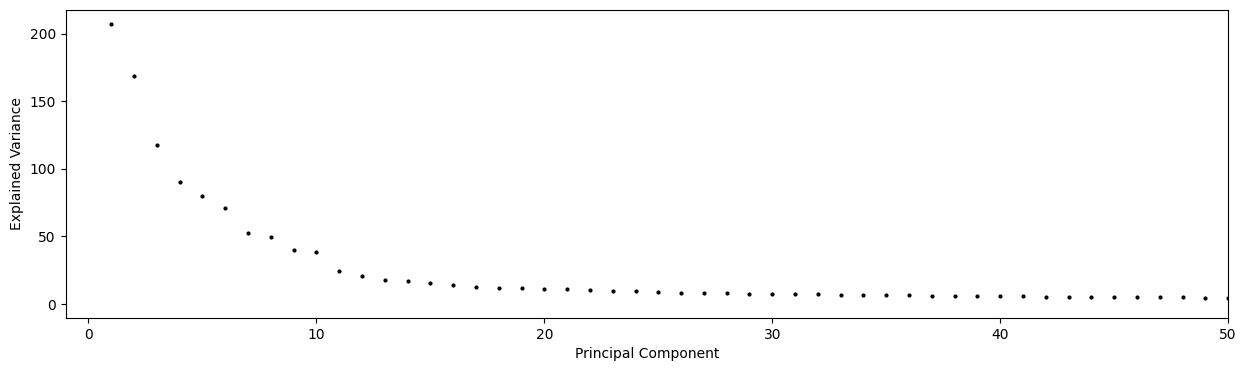

In [7]:
##### Scree plot to visualize effect of num of PC ######
pca = PCA().fit(X_train)

fig = plt.figure(figsize=(15, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'ok', markersize=2)
#ax.axvline(6, linestyle="dashed", color="red", linewidth=1)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance")
ax.set_xlim([-1,50])

In [8]:
####### Cross-validation to find optimal num of PC #######

def cross_val_pca(classifier):
    # Define the cross-validation and the range of components to test
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    component_range = range(1, 30)  # Up to 50 components, for example

    # Store average scores for each number of components
    scores = []

    for n_components in component_range:
        # Create a PCA object with the current number of components
        pca = PCA(n_components=n_components)
        
        # Create a logistic regression classifier
        #classifier = LogisticRegression(max_iter=10000)  # Increase max_iter
        
        # Make a pipeline combining PCA and the classifier
        pipeline = make_pipeline(pca, classifier)
        
        # Perform cross-validation and store the average score
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, verbose = 1)
        scores.append(np.mean(cv_scores))

    # Find the number of components with the highest average score
    optimal_components = component_range[np.argmax(scores)]

    print(f"Optimal number of components: {optimal_components}, Validation error: {scores[optimal_components]}")

    return optimal_components

def plot(X_test_pca, y_pred):  
    pca = PCA(n_components=2)
    X_test_pca_2d = pca.fit_transform(X_test_pca)
    plt.figure(figsize=(4, 4))

    for i in range(len(y_test)):
        color = 'green' if y_test.iloc[i] == y_pred[i] else 'red'
        plt.scatter(X_test_pca_2d[i][0], X_test_pca_2d[i][1], c=color)

    plt.title('Correct/Incorrect Classifications')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()


####### Evaluate #######
def evaluate(optimal_components, classifier):
    pca = PCA(n_components=optimal_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Fit the model on the PCA-transformed training data
    classifier.fit(X_train_pca, y_train)
    y_pred_train = classifier.predict(X_train_pca)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='weighted')  # Use weighted average for multiclass classification
    precision_train = precision_score(y_train, y_pred_train, average='weighted')  # Use weighted average for multiclass classification
    print(f"Training Accuracy: {accuracy_train}, Recall: {recall_train}, Precision: {precision_train}")


    # Make predictions on the PCA-transformed test data
    predictions = classifier.predict(X_test_pca)
    plot(X_test_pca, predictions)
    # Compute metrics 
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions, average='weighted')  # Use weighted average for multiclass classification
    precision = precision_score(y_test, predictions, average='weighted')  # Use weighted average for multiclass classification
    print(f"Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}")



In [9]:
for k in [5, 100, 200]:
    print(f"========== k: {k} ==========")
    classifier = KNeighborsClassifier(n_neighbors=k)
    optimal_components = cross_val_pca(classifier)
    evaluate(optimal_components, classifier)

print(f"========== LR ==========")
classifier = LogisticRegression(max_iter=10000) 
optimal_components = cross_val_pca(classifier)
evaluate(optimal_components, classifier)
    

========== k: 5 ==========


KeyboardInterrupt: 

In [10]:
variances = X_train.iloc[:, :-1].var()

plt.figure(figsize=(8, 5))
plt.plot(variances[variances > 1], 'o')
plt.title('Variances of Columns')
plt.xlabel('Column')
plt.ylabel('Variance')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [11]:
from sklearn.feature_selection import VarianceThreshold

# Example threshold: Variance with a cutoff of 0.1
selector = VarianceThreshold(threshold=0.1)
X_high_variance = selector.fit_transform(X_train)

print("Original feature count:", X_train.shape[1])
print("Reduced feature count:", X_high_variance.shape[1])


Original feature count: 2000
Reduced feature count: 1982


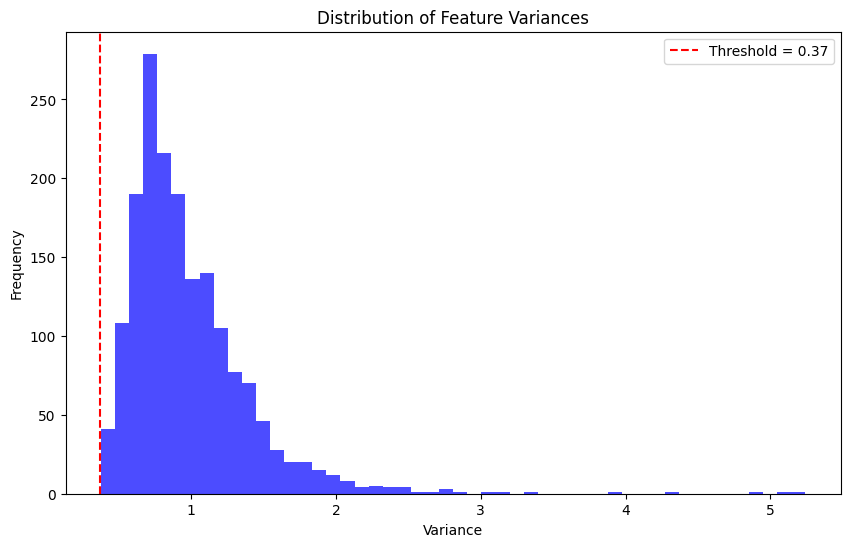

In [24]:
import matplotlib.pyplot as plt

# Calculate the variance of each feature
feature_variances = np.var(X_train, axis=1)
threshold = 0.37
# Plotting the distribution of feature variances
plt.figure(figsize=(10, 6))
plt.hist(feature_variances, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Feature Variances')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.axvline(x=threshold, color='red', linestyle='dashed', label=f'Threshold = {threshold}')
plt.legend()
plt.show()


In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# List of possible thresholds to test
thresholds = [0.01, 0.05, 0.1, 0.15, 0.2]

best_score = 0
best_threshold = 0

for threshold in thresholds:
    selector = VarianceThreshold(threshold=threshold)
    X_reduced = selector.fit_transform(X_train)
    model = RandomForestClassifier()
    scores = cross_val_score(model, X_reduced, y_train, cv=5)
    average_score = np.mean(scores)
    print(f"Threshold: {threshold}, Score: {average_score}")
    
    if average_score > best_score:
        best_score = average_score
        best_threshold = threshold

print(f"Best Threshold: {best_threshold} with a score of {best_score}")


Threshold: 0.01, Score: 0.9884542986123837
Threshold: 0.05, Score: 0.9913361429927872
Threshold: 0.1, Score: 0.9919141776748679
Threshold: 0.15, Score: 0.9919175092868684
Threshold: 0.2, Score: 0.9907614399227066
Best Threshold: 0.15 with a score of 0.9919175092868684
